In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os, getpass
from google.colab import userdata
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import operator
from typing import List, Annotated, Dict
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import pickle
from langgraph.constants import Send
import json
from typing import Dict, Any
from IPython.display import Image
from langgraph.graph import END, StateGraph, START
import warnings

from final_feedback_prompt import final_feedback_instruction
from judgement_prompt import judgement_instructions


## environment setting

In [6]:
# Ignore the specific Pydantic warning
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pydantic")


os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Objects define

In [7]:

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    step_role: str = Field(
        description="Specific step of Gibbs’ Cycle assigned to the analyst",
    )
    description: str = Field(

        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.step_role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class FinalFeedback(BaseModel):
    is_reflection:int
    grades: Dict[str, int] = Field(..., description="Grades for each step of Gibbs' Cycle.")
    feedback: str = Field(..., description="Overall feedback on the reflection.")

class OverallState(TypedDict):
    topic: str
    reflection_input:str
    question:str
    course_name:str
    analysts: List[Analyst] # Analyst asking questions
    judgements: Annotated[list, operator.add]
    final_summarized_output: str


class JudgementState(TypedDict):
    analyst:Analyst
    course_name: str = Field(..., description="Name of the course relevant to the reflection.")
    question: str = Field(..., description="The specific question prompting the reflection.")
    reflection_input: str

class Judgement(BaseModel):
    judgement: str = Field(None, description="Detailed feedback for the step.")



In [22]:



def continue_to_judgements(state: OverallState):
    return [Send("generate_judgement", {"analyst": a,
                                        "reflection_input": state["reflection_input"],
                                        "question":state["question"],
                                        "course_name":state["course_name"],
                                        }) for a in state["analysts"]]


def generate_judgement(state: JudgementState):
    # Get state
    analyst = state["analyst"]
    course_name = state["course_name"]
    question = state["question"]
    reflection_input = state["reflection_input"]

    # Generate judgement for specific reflection text
    system_message = judgement_instructions.format(persona=analyst.persona,
                                                   step_role=analyst.step_role,
                                                   course_name=course_name,
                                                   question=question,
                                                   reflection_input=reflection_input)
    structured_llm = llm.with_structured_output(Judgement)
    response = structured_llm.invoke([SystemMessage(content=system_message),
                                                             HumanMessage(content=reflection_input)])
    return {"judgements": [response.judgement]}


def final_feedback(state: OverallState):

    judgements = "\n\n".join(state["judgements"])
    prompt = final_feedback_instruction.format(
                                               reflection_input=state['reflection_input'],
                                               analysts_judgments=judgements)
    response = llm.with_structured_output(FinalFeedback, method="json_mode").invoke(prompt)
    return {"final_summarized_output": [response.model_dump()]}

## build langgraph

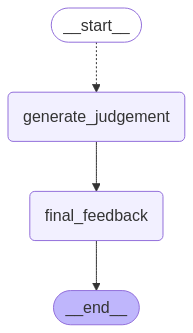

In [23]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_judgement", generate_judgement)
graph.add_node("final_feedback", final_feedback)
# graph.add_edge(START, "create_analysts")
graph.add_conditional_edges(START, continue_to_judgements, ["generate_judgement"])
graph.add_edge("generate_judgement", "final_feedback")
graph.add_edge("final_feedback", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

Function used to call API for output

In [26]:
with open('analysts.txt', 'r') as f:
      analysts_data = json.load(f)
      analysts = [Analyst(**analyst_data) for analyst_data in analysts_data]

# this topic term "General Reflection" already saved in the analyst pickle file
def analyze_reflection(topic="General Reflection", reflection_input=None, course_name="Independent Study", question=None):

    generated_messages = []
    for s in app.stream({"topic": topic,
                         "analysts": analysts,
                         "reflection_input": reflection_input,
                         "course_name": course_name,
                         "question": question
                        }):
        generated_messages.append(s)
    result = generated_messages[-1].get('final_feedback').get('final_summarized_output')[0]
    return result

# Testing

In [30]:

# Example data

reflection_input = "The difference between Regressions and Classifications. For me these topics were not completely new but far away for applying them  after the last module the fog lifted and I have a clearer view again even though there is still to learn on application usage and limitations of these subjects"
question = "What do you know now that you didnt know before the last module"
# Call the analyze_reflection function
result = analyze_reflection(reflection_input=reflection_input, question=question)

# Print the result
print(result)

{'is_reflection': 1, 'grades': {'Description': 1, 'Feelings': 1, 'Evaluation': 0, 'Analysis': 1, 'Conclusion': 1, 'Action_plan': 0}, 'feedback': 'Your reflection effectively describes your experience and conveys your feelings about gaining clarity. However, the evaluation lacks depth; consider discussing specific challenges you faced with regressions and classifications. Additionally, your action plan is missing. Outline concrete steps you plan to take to deepen your understanding, such as practicing with datasets or seeking additional resources.'}
